In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import *
from sklearn.preprocessing import*
import datetime,time
from sklearn.metrics import*
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import re

pd.options.display.float_format = '{:.7f}'.format
pd.set_option('display.max_columns', None)

In [4]:
df_all = pd.read_csv('D:/project/homecredit/final/v3/Application_train_ETL_v3.csv')

In [5]:
obj_columns = df_all.select_dtypes(include=['object']).columns
df_all = pd.get_dummies(df_all, columns=obj_columns, drop_first=True).drop(columns='CODE_GENDER_XNA')


df_all = df_all.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x.replace(' ', '')))

X = df_all.drop(columns=['SK_ID_CURR', 'TARGET'])
y = df_all['TARGET']


In [6]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.1, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

[LightGBM] [Info] Number of positive: 22306, number of negative: 254453
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3267
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 132
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080597 -> initscore=-2.434260
[LightGBM] [Info] Start training from score -2.434260
迭代 10次，valid_AUC = 0.7442
迭代 20次，valid_AUC = 0.7509
迭代 30次，valid_AUC = 0.7572
迭代 40次，valid_AUC = 0.7610
迭代 50次，valid_AUC = 0.7631
迭代 60次，valid_AUC = 0.7647
迭代 70次，valid_AUC = 0.7653
迭代 80次，valid_AUC = 0.7662
迭代 90次，valid_AUC = 0.7662
迭代 100次，valid_AUC = 0.7666
程式執行花費的时间： 1.77 秒
完成时间: 2023-09-06 20:16:48.555563


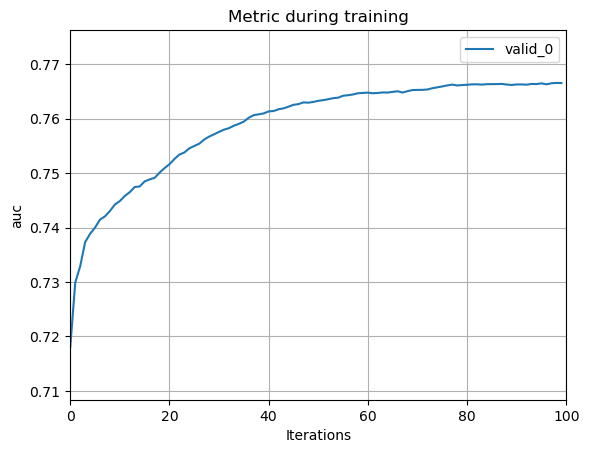

In [10]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_valid = lgb.Dataset(X_valid, label=y_valid, reference=lgb_train)


params = {
    'objective': 'binary',
    'is_unbalance': 'true',
    # 'n_estimators': 500,
    'metric': 'auc',
    'verbose': 1,
    'n_jobs':-1
    # 'device': 'GPU',

            # 'objective': 'binary',
            # 'nthread': 4,
            # 'is_unbalance': 'true',
            # 'n_estimators': 1000,
            # 'learning_rate': 0.03,
            # 'num_leaves': 34,
            # 'colsample_bytree': 0.9497036,
            # 'subsample': 0.8715623,
            # 'max_depth': 8,
            # 'reg_alpha': 0.041545473,
            # 'reg_lambda': 0.0735294,
            # 'min_split_gain': 0.0222415,
            # 'min_child_weight': 39.3259775,
            # 'silent': -1,
            # 'verbose': -1,
            # 'device': 'GPU'
}

evals_result = {}

start_time = time.time()

gbm = lgb.LGBMClassifier(**params)
gbm.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    eval_metric='auc',
    callbacks=[lgb.record_evaluation(evals_result)],
)


end_time = time.time()
execution_time = end_time - start_time


# After training
for iteration, auc_values in enumerate(evals_result['valid_0']['auc'], start=1):
    if iteration % 10 == 0:  # Print every 10 iterations
        print(f'迭代 {iteration}次，valid_AUC = {auc_values:.4f}')

print("程式執行花費的时间：", round(execution_time, 2), "秒")
print("完成时间:", datetime.datetime.now())

# Plot the recorded evaluation metric (AUC)
lgb.plot_metric(evals_result, metric='auc')
plt.show()


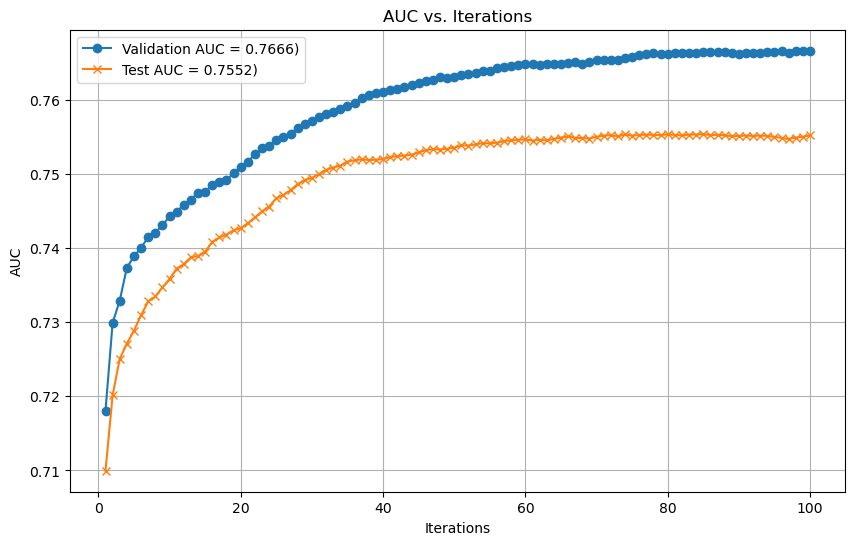

In [11]:
# 初始化验证集和测试集的真实标签
y_true_valid = y_valid
y_true_test = y_test

# 获取迭代次数和AUC值的记录
iterations = np.arange(1, len(evals_result['valid_0']['auc']) + 1)
valid_auc_values = evals_result['valid_0']['auc']

# 初始化存储AUC值的列表
valid_auc = []
test_auc = []

# 根据每个迭代次数计算验证集和测试集的AUC值
for iteration in iterations:
    # 使用模型的predict_proba方法来获取概率值
    y_pred_prob_valid = gbm.predict_proba(X_valid, num_iteration=iteration)[:, 1]
    y_pred_prob_test = gbm.predict_proba(X_test, num_iteration=iteration)[:, 1]
    
    # 计算验证集和测试集的ROC曲线
    fpr_valid, tpr_valid, _ = roc_curve(y_true_valid, y_pred_prob_valid)
    fpr_test, tpr_test, _ = roc_curve(y_true_test, y_pred_prob_test)
    
    # 计算验证集和测试集的AUC值
    roc_auc_valid = auc(fpr_valid, tpr_valid)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    # 将AUC值添加到列表中
    valid_auc.append(roc_auc_valid)
    test_auc.append(roc_auc_test)

# 绘制AUC曲线
plt.figure(figsize=(10, 6))
plt.plot(iterations, valid_auc, label=f'Validation AUC = {valid_auc[-1]:.4f})', marker='o')
plt.plot(iterations, test_auc, label=f'Test AUC = {test_auc[-1]:.4f})', marker='x')
plt.xlabel('Iterations')
plt.ylabel('AUC')
plt.title('AUC vs. Iterations')
plt.legend()
plt.grid(True)
plt.show()


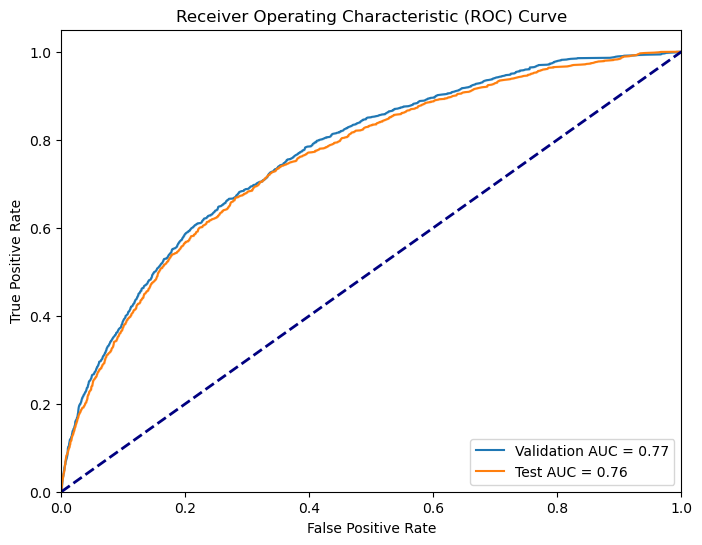

In [12]:
from sklearn.metrics import roc_curve, auc

# 初始化验证集和测试集的真实标签
y_true_valid = y_valid
y_true_test = y_test

# 使用模型的predict_proba方法来获取概率值
y_pred_prob_valid = gbm.predict_proba(X_valid)[:, 1]
y_pred_prob_test = gbm.predict_proba(X_test)[:, 1]

# 计算验证集和测试集的ROC曲线
fpr_valid, tpr_valid, _ = roc_curve(y_true_valid, y_pred_prob_valid)
fpr_test, tpr_test, _ = roc_curve(y_true_test, y_pred_prob_test)

# 计算验证集和测试集的AUC值
roc_auc_valid = auc(fpr_valid, tpr_valid)
roc_auc_test = auc(fpr_test, tpr_test)

# 创建验证集和测试集的ROC曲线数据框
roc_df_valid = pd.DataFrame({'FPR': fpr_valid, 'TPR': tpr_valid})
roc_df_test = pd.DataFrame({'FPR': fpr_test, 'TPR': tpr_test})

# 绘制AUC曲线
plt.figure(figsize=(8, 6))
sns.lineplot(data=roc_df_valid, x='FPR', y='TPR', label=f'Validation AUC = {roc_auc_valid:.2f}')
sns.lineplot(data=roc_df_test, x='FPR', y='TPR', label=f'Test AUC = {roc_auc_test:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Confusion Matrix:
[[9795 4308]
 [ 390  883]]


<Axes: >

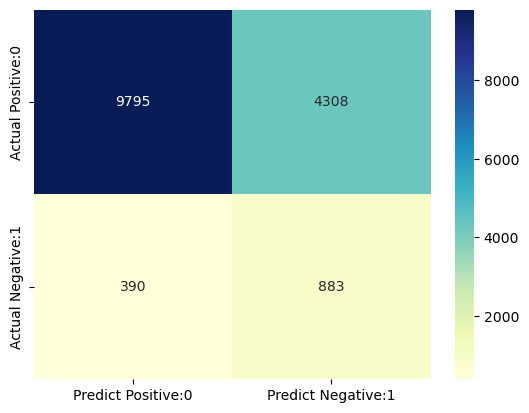

In [13]:
y_pred = gbm.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)

print("Confusion Matrix:")
print(cm)


cm_matrix = pd.DataFrame(data=cm, columns=['Predict Positive:0', 'Predict Negative:1'], 
                                 index=['Actual Positive:0', 'Actual Negative:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

<Figure size 2000x2000 with 0 Axes>

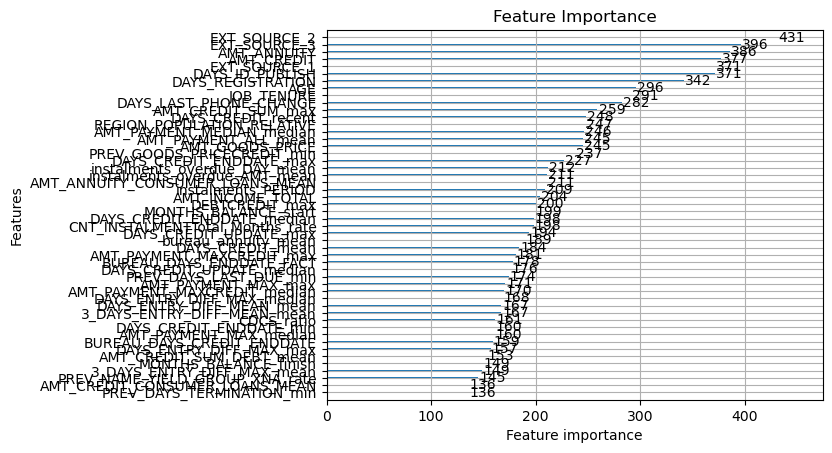

In [11]:
plt.figure(figsize=(20, 20))
lgb.plot_importance(gbm, max_num_features=50)  # Adjust max_num_features as needed
plt.title("Feature Importance")
plt.show()

In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.69      0.79     14130
           1       0.08      0.31      0.13      1246

    accuracy                           0.66     15376
   macro avg       0.50      0.50      0.46     15376
weighted avg       0.85      0.66      0.73     15376

